## Info
Setting up the model to receate the hydrosynamics of the Solitary Wave model from BarSed.

Author: WaveHello

Date: 07/15/2024

### Notes
ADV data and pressure data for the solitary wave cases aren't in the folders I downloaded. I'm not sure where that data is or if it was recorded.

:warning: The velocity input for this model is incorrect. The velocity of the wave maker should be used. Currently a constant velocity is used. :warning:

In [26]:
# import default modules
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import scipy
import pandas as pd
from scipy import special

# Set global constants
PI = np.pi

# method to import xbtools with try routine
try:
    import xbTools
except ImportError:
    print('**no xbTools installation found in environment, adding parent path of notebook to see if it works')
    sys.path.append(r"..\..\..\xbeach-toolbox")

In [27]:
# Import the classes that represent the runs
# Add the library to the path
sys.path.append(r"..\..\..\BarSed_Lib")

# Import the library modules

from lib.data_classes.Run import Run
from lib.general_funcs.signal_processing import moving_average_filter
from lib.general_funcs.kinematic_funcs import calc_velocity
from lib.general_funcs.path_funcs import create_directory_if_not_exists

In [28]:
from xbTools.grid.creation import xgrid
from xbTools.xbeachtools import XBeachModelSetup
from xbTools.xbeachpost import XBeachModelAnalysis
from xbTools.general.executing_runs import generate_batch_script, run_batch_script


In [29]:
# Fuctions
def get_script_directory():
    try:
        # This will work if the script is run directly
        script_path = os.path.abspath(__file__)
    except NameError:
        # This will work in an interactive environment like Jupyter
        script_path = os.path.abspath('')
    
    return script_path


### Set the information for the selected Run

In [30]:
# Import the raw bathymetry
# Set the important paths
barsed_data_path = r"D:\ERDC\BarSed_Data"

# Set the information needed for specifying the run
# Run number
run_number = "082"

# Run id
run_id = f"RUN{run_number}"

# Mat file for the first run
run_name = r"{}.mat".format(run_id)


### Set data that isn't directly available in the inputs

### Get the bathymetry for the model

In [31]:
# Name of the bathy data binary
bathy_file_name = r"bathy.mat"

# Path to where I'm storing the bathymetry data
bathy_file_path = os.path.join(barsed_data_path, bathy_file_name)

print(f"Bathy file path: {bathy_file_path}")

Bathy file path: D:\ERDC\BarSed_Data\bathy.mat


### Get the path to the wave gauge data

In [32]:

# Name of the folder containing the wave data
WG_data_folder_name = r"WG" 

# Path to where I'm storing the bathymetry data
WG_data_path = os.path.join(barsed_data_path, WG_data_folder_name)

# Path to the selected wave gauge data
wave_data_path = os.path.join(WG_data_path, run_name)

print(f"Run{run_number} wave mat file path: {wave_data_path}")

Run082 wave mat file path: D:\ERDC\BarSed_Data\WG\RUN082.mat


### Get the path to the adv data
The period of the wave maker is stored in this data. Not using it for anything else at the momement.

In [33]:
# Name of the folder containing the adv data
ADV_data_folder_name = r"ADV"

# Path to where the velocity data is being stored
ADV_data_path = os.path.join(barsed_data_path, ADV_data_folder_name)

# Path to the adv data for the selected run
ADV_file_path = os.path.join(ADV_data_path, run_name)

print(f"{ADV_data_folder_name} file path: {ADV_data_path}")
print("{} Data for mat file path: {}".format(ADV_data_folder_name, ADV_file_path))

ADV file path: D:\ERDC\BarSed_Data\ADV
ADV Data for mat file path: D:\ERDC\BarSed_Data\ADV\RUN082.mat


### Collect the bathymetry data

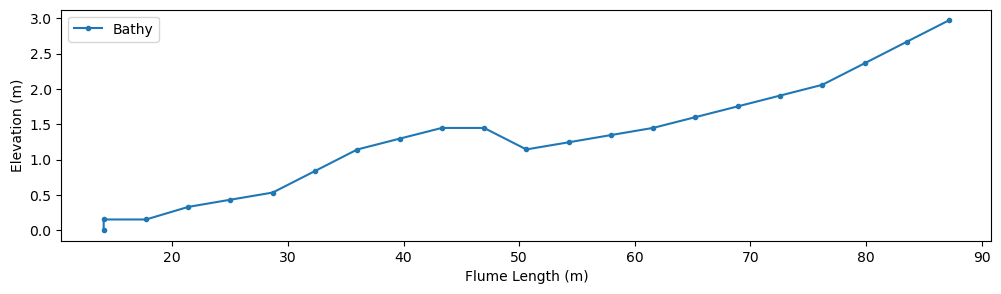

In [34]:
# Make a plot of the bathymetry to make sure the data is right
# Load the .mat file
bathy_dict = scipy.io.loadmat(bathy_file_path)

# Get the bathymetry data
bathy_df = pd.DataFrame(bathy_dict["bathy"], columns = ["x_loc", "z_loc"])

bathy_df.plot("x_loc", "z_loc", marker = ".", 
              figsize = (12, 3), label = "Bathy", 
              ylabel= "Elevation (m)", xlabel = "Flume Length (m)"
)

plt.legend()
plt.show()

### Construct the Run object
This object will help organize the data and help store the data

In [35]:
Run_data = Run(id = run_id, wave_file_path=wave_data_path,
              ADV_file_path = ADV_file_path)

print(Run_data)


id: RUN082
Start Date: None
Wave Data File path: D:\ERDC\BarSed_Data\WG\RUN082.mat
Num pressure gagues: None
Num advs: None


### Collect the wave gauge data

New Number of 17 wave gauges
Wave Maker information:
Number of times: 8362


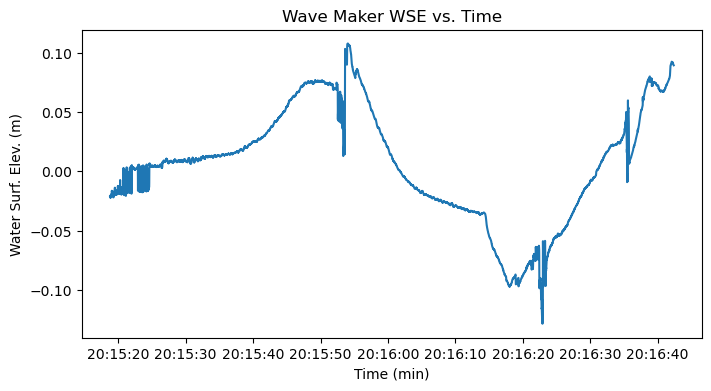

In [36]:
Run_data.load_wave_data()

print(Run_data.wave_maker)

Run_data.wave_maker.quick_wse_plot()

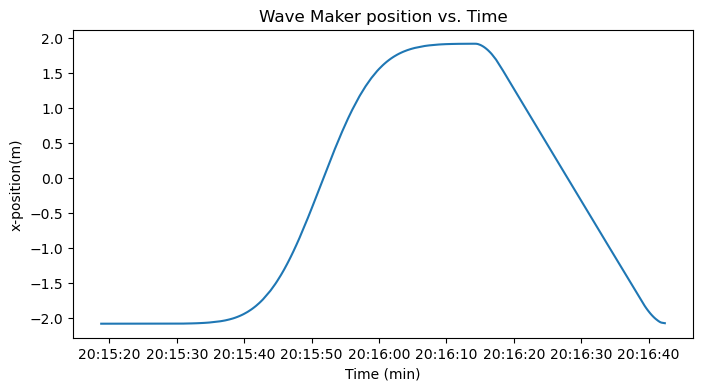

In [37]:
Run_data.wave_maker.quick_position_plot()

## Smoothing the surface data

In [38]:
# Convert the wave maker date_time to time in seconds
first_time = Run_data.wave_maker.date_time[0]

seconds_from_first = np.array([(dt - first_time).total_seconds() for dt in Run_data.wave_maker.date_time])


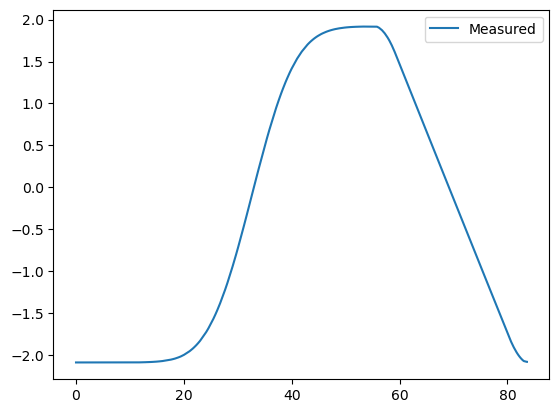

In [39]:
# Plot the theoretical and the measured wave maker displacement

fig, axs = plt.subplots(nrows = 1, ncols = 1)

axs = np.atleast_1d(axs)

shift = 10
wave_maker_loc = Run_data.wave_maker.position
axs[0].plot(seconds_from_first, wave_maker_loc, label = "Measured")

plt.legend()
plt.show()

## Generating the xBeach inputs

### Generating the Bathymetry

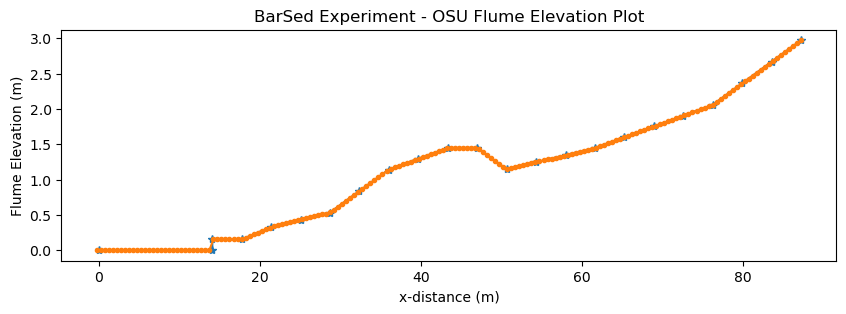

In [40]:
# Set information
zs0 = 2.448 # From Mieras et al. in excel logsheet

# Reinterpolate the raw bathymetry for the xBeach model

x = np.array(bathy_df["x_loc"])
z = np.array(bathy_df["z_loc"])

# Add the zero to the arrays
x = np.concatenate(([0.0], x))
z = np.concatenate(([0.0], z))

# x_zero = np.array(0, )
xgr, zgr = xgrid(x, z, dxmax = 0.1, dxmin = 0.5)


fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize = (10, 3))

# Convert axs to an array so I can iterate over it if needed
axs = np.atleast_1d(axs)

axs[0].plot(x, z    , marker = "*", label = "Bathy")
axs[0].plot(xgr, zgr, marker = ".", label = "xgr")
# axs[0].axhline(y = 3.0)
axs[0].set_xlabel("x-distance (m)")
axs[0].set_ylabel("Flume Elevation (m)")

plt.title("BarSed Experiment - OSU Flume Elevation Plot")
plt.show()
#TODO: Need to look into what the proper procedure for 


### Generating the wave data

In [41]:
print(Run_data)

id: RUN082
Start Date: 2015-01-30
Wave Data File path: D:\ERDC\BarSed_Data\WG\RUN082.mat
Num pressure gagues: None
Num advs: None


In [42]:
print(Run_data.wave_gauges[0])

Wave Gauge Type: self_calibrating
Gauge Id: 1
Location: (17.728, -1.269)


### Generate the horizontal velocity
The OSU wave maker is vertical, it doesn't pivot and it has active absorbing


In [62]:
x0 = wave_maker_loc
u_avg = calc_velocity(x0, seconds_from_first)

In [44]:
# Offset the water suface elevation from the bottom
eta = zs0 + Run_data.wave_maker.eta_wm

In [45]:
window_size = 75
# Smooth the water surface elevation
smoothed_eta  = moving_average_filter(eta, window_size)

# Smooth the time
smoothed_time = moving_average_filter(seconds_from_first, window_size) 

# Smooth the velocity
smoothed_u = moving_average_filter(u_avg, window_size)


In [46]:
# Addding a the initial values to offset from the smoothing

# Making the initial velocity zero
smoothed_u  = np.insert(smoothed_u, 0, 0.0)

# Making the initial surface elevation zs0
smoothed_eta[0] = zs0

# Make the initial time zreo
smoothed_time[0] = 0.0

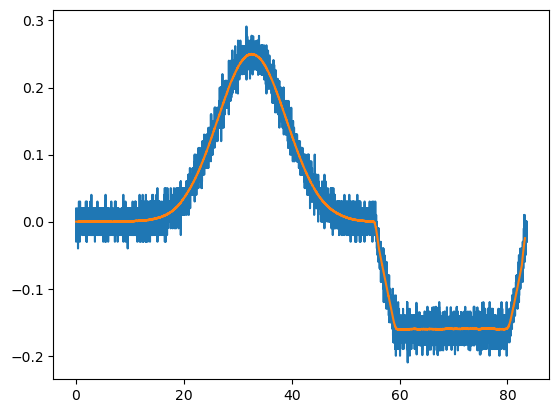

In [63]:
plt.plot(seconds_from_first[1:], u_avg, label = "Calculated ")
plt.plot(smoothed_time, smoothed_u, label = "Smoothed")
plt.show()

In [53]:
# Checking that they're all the same length
print(len(smoothed_u))
print(len(smoothed_eta))
print(len(smoothed_time))

8288
8288
8288


Water surface elevation: 2.448 [m]


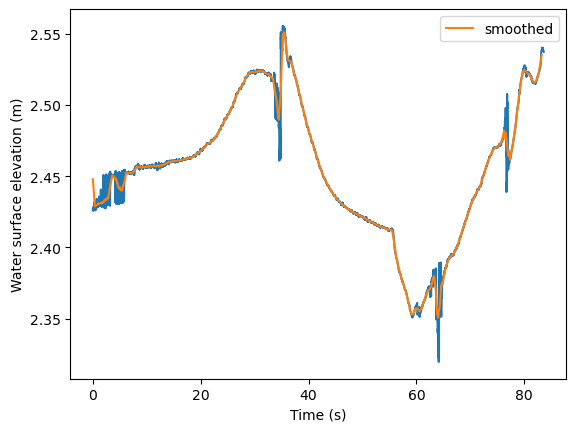

In [54]:
print(f"Water surface elevation: {zs0} [m]")
plt.plot(seconds_from_first, eta)
plt.plot(smoothed_time, smoothed_eta, label ="smoothed")
plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("Water surface elevation (m)")
plt.show()

### Generating the computational params for the model

In [55]:
xb_setup = XBeachModelSetup('Rand_vel_v1_1')

xb_setup.set_grid(xgr, None, zgr, posdwn=-1, alfa=0)
xb_setup.set_nebed(np.ones_like(zgr))
xb_setup.set_friction(np.ones_like(zgr))

In [56]:
# Generate a random u velocity for the time being
u_avg = np.ones(len(smoothed_time)) * 0.1

zs_scaling = 1.0

boun_U_dict = {"make_file": True,
               "file_name": "boun_U.bcf",
               "dimension": "vector",
               "variable_dict": {
                   "t" : smoothed_time,
                   "U" : smoothed_u, # NOTE: Changed these to surface velocities 
                   "zs": zs_scaling * (smoothed_eta - zs0) # Pertubation from the intial water surface
               }         
}

xb_setup.set_waves('ts_nonh', input_struct=boun_U_dict)

tolerance = 0.01
if abs(zs_scaling-1.0) > tolerance:
    print(f"WARNING: USING a zs scaling of {zs_scaling}. This doesn't make physical sense")


In [57]:
xb_setup.set_params({ "wbctype"     : "ts_nonh",
                     "wavemodel"    : "nonh",
                     "nonh"         : 1,
                     "CFL"          : 0.5,
                     'nonhq3d'      : 1,
                     'nhlay'        : 0.33, 
                     "lateralwave"  : "neumann",
                     "zs0"          : zs0,
                     'bedfriccoef'  : 0.015,
                     "ARC"          : 1,
                     "front"        : "nonh_1d", "back" : "abs_1d",
                     "left"         : "wall"   , "right": "wall",
                     "tstop"        : smoothed_time.max(),
                     "outputformat" : "netcdf",
                     "tintm"        : 0.1,
                     "tintp"        : 0.1,
                     "tintg"        : 0.1,
                     'nglobalvar'   : ['zs', 'zb', 'H', "u", "v"],
})

The following params were not found in the JSON: 
{'nonh': 1}


In [58]:
xb_setup.input_par

{'par': {'nonh': 1},
 'Wave boundary condition parameters': {'wbctype': 'ts_nonh',
  'lateralwave': 'neumann'},
 'Physical processes': {'wavemodel': 'nonh'},
 'Model time': {'CFL': 0.5, 'tstop': 83.24000049333334},
 'Non-hydrostatic correction parameters': {'nonhq3d': 1, 'nhlay': 0.33},
 'Tide boundary conditions': {'zs0': 2.448},
 'Flow parameters': {'bedfriccoef': 0.015},
 'Flow boundary condition parameters': {'ARC': 1,
  'front': 'nonh_1d',
  'back': 'abs_1d',
  'left': 'wall',
  'right': 'wall'},
 'Output': {'outputformat': 'netcdf',
  'tintm': 0.1,
  'tintp': 0.1,
  'tintg': 0.1},
 '_Output': {'nglobalvar': ['zs', 'zb', 'H', 'u', 'v']}}

### Generating the model files

In [59]:
# Get the folder of the current script
script_dir = get_script_directory()

# Generate the model directory
model_dir = os.path.join(script_dir, f"")

create_directory_if_not_exists(model_dir)

exe_path = r"..\..\..\XBeach_1.24.6057_Halloween_win64_netcdf\xbeach.exe"

# Make the batch file in the model dir
generate_batch_script(model_dir, exe_path, batch_file_name = "run_model.bat", 
                      include_cd = False, batch_file_folder = None)


batch_file_path = os.path.join(model_dir, "run_model.bat")


Directory 'e:\BarSed_xBeach_Models\Solitary_wave_models\Run_082_nonhq3d\' already exists.


In [60]:
xb_setup.write_model(model_dir, num_dec_dig=10)

Data written to e:\BarSed_xBeach_Models\Solitary_wave_models\Run_082_nonhq3d\boun_U.bcf


In [64]:
# Write the wave maker data to a txt file

# Time, location, wse
data = {"time"     : seconds_from_first,     
        "location" : Run_data.wave_maker.position,
        "wse"      : Run_data.wave_maker.eta_wm + zs0
        }
df = pd.DataFrame(data)
display(df)
df.to_csv("wave_maker.csv", index = False)

,time,location,wse
0,0.000000,-2.0847,2.426702
1,0.009998,-2.0847,2.426380
2,0.020006,-2.0850,2.426316
3,0.030004,-2.0848,2.426960
4,0.039992,-2.0847,2.426960
...,...,...,...
8357,83.570006,-2.0770,2.537711
8358,83.580004,-2.0771,2.537711
8359,83.590002,-2.0774,2.537518
8360,83.599999,-2.0774,2.537518
